# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 33 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
display('Дубликатов в данных:', data.duplicated().sum())

'Дубликатов в данных:'

4

In [7]:
# удалим дубликаты
data = data.drop_duplicates(keep='first')

In [8]:
# обработка столбца с датой создания анкеты
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')

In [9]:
# посмотрим на года публикации объявлений
data['DateCreated'].dt.year.unique()

array([2016, 2015, 2014])

In [10]:
# удалим столбцы, которые не играют роли в определении цены автомобиля
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode', 'RegistrationMonth'], axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>],
       [<AxesSubplot:title={'center':'Power'}>,
        <AxesSubplot:title={'center':'Kilometer'}>]], dtype=object)

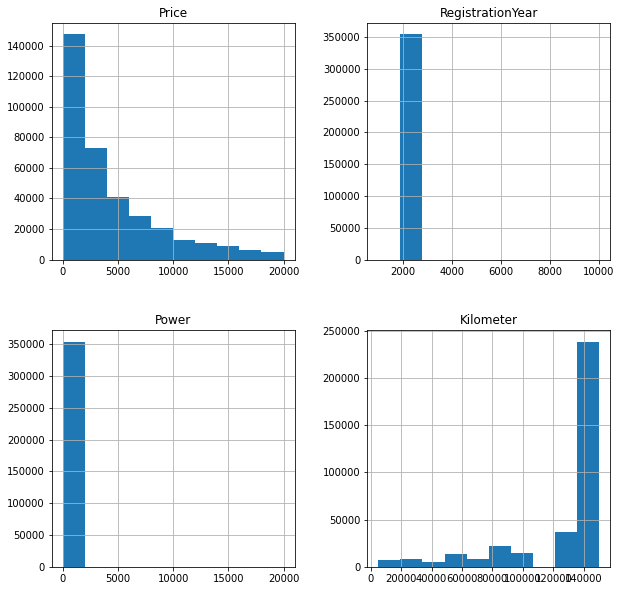

In [11]:
data.hist(figsize=(10, 10))

In [12]:
data.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,321470,354365,283211
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268249,NaN,29232,NaN,216349,77012,247158
mean,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,NaN,NaN,NaN
std,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN


In [13]:
# посмотрим на пропуски в данных
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

In [14]:
# посмотрим на уникальные значения и их количество по ремонту авто
data['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

<AxesSubplot:title={'center':'Цена автомобиля в зависимости от года выпуска'}, xlabel='Price', ylabel='RegistrationYear'>

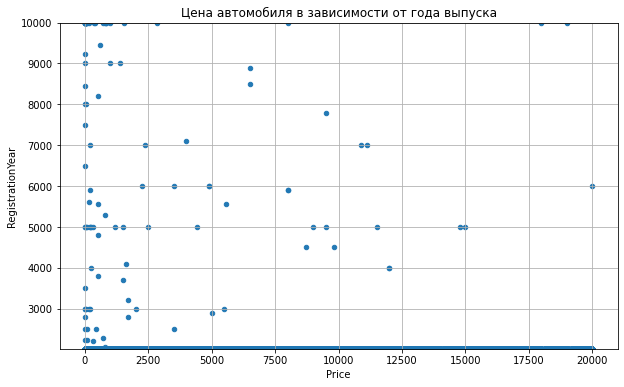

In [15]:
# посмотрим на выбросы по году автомобиля
data.plot(
    x='Price', 
    y='RegistrationYear', 
    kind='scatter', figsize=(10,6), 
    ylim=(2016, 10000), 
    title='Цена автомобиля в зависимости от года выпуска', 
    alpha=0.98, 
    grid=True
)

In [16]:
# посмотрим много ли строк с ценой автомобиля меньше 100 евро
data.loc[data['Price'] < 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


In [17]:
# удалим строки с ценой автомобиля менее 100, т.к. их всего 3%
data = data.loc[data['Price'] > 100]

In [18]:
#посмотрим на количество автомобилей с годом выпуска более 2016г
data.loc[data['RegistrationYear'] > 2016, 'RegistrationYear'].count()

13673

In [19]:
# удалим строки с годом выпуска автомобиля более 2016 года, т.к их совсем немного
data = data.loc[data['RegistrationYear'] <= 2017]

In [20]:
#посмотрим на количество автомобилей с годом выпуска менее 1900г
data.loc[data['RegistrationYear'] < 1900, 'RegistrationYear'].count()

40

In [21]:
# удалим строки с годом выпуска автомобиля менее 1900 года, т.к их совсем немного
data = data.loc[data['RegistrationYear'] > 1900]

In [22]:
# посмотрим на уникальные значения и их количество по типу топлива
data['FuelType'].value_counts()

petrol      207268
gasoline     96297
lpg           5109
cng            544
hybrid         225
other          151
electric        85
Name: FuelType, dtype: int64

In [23]:
# есть ли  строки с нулевой мощностью автомобиля
data.loc[data['Power'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...
354336,3299,NaN,2005,auto,0,outlander,150000,petrol,mitsubishi,NaN
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [24]:
# есть ли  строки с мощностью автомобиля более 500
data.loc[data['Power'] > 500]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,12500,NaN,2017,manual,2000,other,60000,gasoline,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [25]:
# удалим строки с нулевой мощностью автомобиля и более 500
data = data.loc[(data['Power'] != 0) & (data['Power'] < 500)]

In [26]:
# посмотрим на уникальные значения и их количество по типу автомобильного кузова
data['VehicleType'].value_counts()

sedan          82742
small          69392
wagon          59037
bus            26163
convertible    18733
coupe          14520
suv            10929
other           2468
Name: VehicleType, dtype: int64

In [27]:
# посмотрим на уникальные значения и их количество по типу коробки передач
data['Gearbox'].value_counts()

manual    236583
auto       59735
Name: Gearbox, dtype: int64

In [28]:
# посмотрим на уникальные значения марок автомобилей
data['Brand'].value_counts()

volkswagen        65751
opel              33213
bmw               32722
mercedes_benz     27746
audi              26099
ford              21002
renault           14254
peugeot            9541
fiat               7815
seat               6008
skoda              5013
mazda              4812
smart              4573
citroen            4349
nissan             4119
toyota             4082
hyundai            3167
mini               3016
volvo              2849
mitsubishi         2537
honda              2426
kia                2133
alfa_romeo         2008
suzuki             1984
sonstige_autos     1859
chevrolet          1476
chrysler           1177
dacia               812
subaru              647
porsche             620
daihatsu            619
jeep                588
saab                479
land_rover          466
jaguar              434
daewoo              415
lancia              388
rover               375
trabant             291
lada                157
Name: Brand, dtype: int64

In [29]:
# после удаления кривых строк обновим индексацию
data = data.reset_index(drop=True) 

**ВЫВОД: Признак, который нужно предсказать, — целевой: в нашей задаче это цена автомобиля (Price). Такие задачи относятся к классу «обучение с учителем». Целевой признак числовой, т.о. мы будем решать задачу регрессии.**

## Обучение моделей

In [30]:
# выделим целевой признак
features = data.drop(['Price'], axis=1)
target = data['Price']

In [31]:
# создадим список с числовыми столбцами для масштабирования
numerical = features.select_dtypes(include='int64').columns.to_list()
numerical

['RegistrationYear', 'Power', 'Kilometer']

In [32]:
# создадим список с категориальными столбцами для кодирования
to_dummies = features.select_dtypes(include='object').columns.to_list()
to_dummies

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [33]:
# сначала выделим обучающую выборку
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, 
    test_size=0.4, 
    random_state=12345)

In [34]:
# заменим пропуски на заглушку "missing"
imputer = SimpleImputer(strategy='constant', fill_value='missing')
features_train_imputed = imputer.fit_transform(features_train)

In [35]:
features_train = pd.DataFrame(features_train_imputed, columns=features_train.columns)
features_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,small,2006,manual,68,1_reihe,100000,petrol,peugeot,no
1,suv,2007,auto,150,cr_reihe,90000,petrol,honda,no
2,wagon,1999,auto,116,golf,150000,petrol,volkswagen,no
3,bus,2005,manual,115,alhambra,150000,gasoline,seat,missing
4,missing,2017,manual,65,picanto,150000,lpg,kia,yes
...,...,...,...,...,...,...,...,...,...
181208,sedan,1985,manual,136,e_klasse,150000,petrol,mercedes_benz,no
181209,sedan,2000,manual,143,e_klasse,150000,gasoline,mercedes_benz,no
181210,sedan,2005,auto,306,e_klasse,150000,petrol,mercedes_benz,no
181211,sedan,1999,manual,150,a6,150000,gasoline,audi,missing


In [36]:
features_valid_imputed = imputer.transform(features_valid)

In [37]:
features_valid = pd.DataFrame(features_valid_imputed, columns=features_valid.columns)
features_valid

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,bus,2004,manual,101,meriva,125000,petrol,opel,no
1,missing,2005,manual,140,a3,150000,missing,audi,missing
2,wagon,2003,manual,75,fabia,150000,petrol,skoda,no
3,wagon,2006,manual,170,passat,150000,gasoline,volkswagen,no
4,small,2001,manual,80,punto,100000,petrol,fiat,no
...,...,...,...,...,...,...,...,...,...
120804,wagon,1995,manual,192,5er,150000,petrol,bmw,yes
120805,sedan,1998,manual,75,almera,150000,petrol,nissan,no
120806,suv,2003,manual,116,pajero,150000,gasoline,mitsubishi,no
120807,sedan,2006,auto,140,civic,150000,petrol,honda,no


In [38]:
# приведем признаки к нужному типу
features_train[to_dummies] = features_train[to_dummies].astype(str)
features_valid[to_dummies] = features_valid[to_dummies].astype(str)
features_train[numerical] = features_train[numerical].astype(int)
features_valid[numerical] = features_valid[numerical].astype(int)

In [39]:
# теперь поделим пополам на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, 
    test_size=0.5, 
    random_state=12345)

In [40]:
# Проконтролируем корректностью разбиения
print(features_train.shape)
print(features_valid.shape)
features_test.shape

(181213, 9)
(60404, 9)


(60405, 9)

In [41]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181213 entries, 0 to 181212
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       181213 non-null  object
 1   RegistrationYear  181213 non-null  int64 
 2   Gearbox           181213 non-null  object
 3   Power             181213 non-null  int64 
 4   Model             181213 non-null  object
 5   Kilometer         181213 non-null  int64 
 6   FuelType          181213 non-null  object
 7   Brand             181213 non-null  object
 8   Repaired          181213 non-null  object
dtypes: int64(3), object(6)
memory usage: 12.4+ MB


**Для линейной регрессии LinearRegression преобразуем все признаки и используем конвейер**

In [42]:
# Объявляем scaler и OneHotEncoder() для числовых и категориальных переменных
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [43]:
# Делаем pipeline для числовых переменных датасета
numerical_selector = FunctionTransformer(
    lambda features_train: features_train[numerical], validate=False
)
numerical_preprocessor = Pipeline(
    [("numerical_selector", numerical_selector), ("scaling", scaler)]
)
# Делаем pipeline для категориальных переменных датасета
dummy_selector = FunctionTransformer(
    lambda features_train: features_train[to_dummies], validate=False
)
dummy_preprocessor = Pipeline(
    [("dummy_selector", dummy_selector), ("ohe", ohe)]
)

In [44]:
# Объединяем созданные выше pipeline в один с помощью функции FeatureUnion и затем записываем итоговый pipeline c логистической регрессией
feature_union = FeatureUnion([("numerical_preprocessor", numerical_preprocessor),
("dummy_preprocessor", dummy_preprocessor)])

In [45]:
%%time 
#Теперь можно обучить модель
pipeline = Pipeline(
    [("preprocessing", feature_union),
    ('model', LinearRegression())]
)
pipeline.fit(features_train, target_train)

# И наконец predict
preds = pipeline.predict(features_valid)

mse = mean_squared_error(target_valid, preds) 
rmse = mse**0.5 
print('Среднеквадратическая ошибка для модели LinearRegression составляет:', rmse)

Среднеквадратическая ошибка для модели LinearRegression составляет: 77890881775.23668
CPU times: user 16.6 s, sys: 24.5 s, total: 41 s
Wall time: 41.1 s


**Модель градиентного бустинга CatBoost работает с категориальными признаками просто: такса остаётся таксой, а стаффорд — стаффордом. Кодировать в 1 или 0 не нужно. Преобразовывать нужно только числовые. У CatBoost есть свой grid_search.**

In [46]:
features_train_cat = features_train.copy()
features_valid_cat = features_valid.copy()

In [47]:
# Возьмем кодировщик RobustScaler - он не подвержен влиянию выбросов
scaler = RobustScaler()
scaler.fit(features_train_cat[numerical]) 
features_train_cat[numerical] = scaler.transform(features_train_cat[numerical])
features_valid_cat[numerical] = scaler.transform(features_valid_cat[numerical])
features_test[numerical] = scaler.transform(features_test[numerical])

In [48]:
%%time 
model = CatBoostRegressor(loss_function="RMSE", depth=5, iterations=20)
model.fit(features_train_cat, target_train, cat_features=to_dummies, verbose=10)
# предсказания
pred_valid = model.predict(features_valid_cat)
# расчет оценки
mse = mean_squared_error(target_valid, pred_valid) 
rmse = mse**0.5 
print('Среднеквадратическая ошибка для модели CatBoostRegressor составляет:', rmse)

Learning rate set to 0.5
0:	learn: 3368.2542056	total: 154ms	remaining: 2.94s
10:	learn: 1956.6765498	total: 992ms	remaining: 812ms
19:	learn: 1869.9558885	total: 1.69s	remaining: 0us
Среднеквадратическая ошибка для модели CatBoostRegressor составляет: 1884.36584406007
CPU times: user 2.03 s, sys: 72.2 ms, total: 2.1 s
Wall time: 3.26 s


**LGBMRegressor - это градиентный бустинг над решающими деревьями ("деревянная" модель, не линейная). Для неё подойдет порядковое кодирование, так как деревья умеют разделять категориальные признаки, закодированные в любом порядке.**

In [49]:
features_train_lg = features_train.copy()
features_valid_lg = features_valid.copy()

In [50]:
# признак Repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал
col_transformer_lgbm = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        to_dummies
    ),
    remainder='passthrough'
)

In [51]:
features_train_lgbm = pd.DataFrame(
    col_transformer_lgbm.fit_transform(features_train_lg),
    columns=col_transformer_lgbm.get_feature_names_out()
) 
features_train_lgbm.head()

,ordinalencoder__VehicleType,ordinalencoder__Gearbox,ordinalencoder__Model,ordinalencoder__FuelType,ordinalencoder__Brand,ordinalencoder__Repaired,remainder__RegistrationYear,remainder__Power,remainder__Kilometer
0,6.0,1.0,5.0,7.0,25.0,1.0,2006.0,68.0,100000.0
1,7.0,0.0,84.0,7.0,11.0,1.0,2007.0,150.0,90000.0
2,8.0,0.0,116.0,7.0,38.0,1.0,1999.0,116.0,150000.0
3,0.0,1.0,36.0,2.0,30.0,0.0,2005.0,115.0,150000.0
4,3.0,1.0,173.0,4.0,15.0,2.0,2017.0,65.0,150000.0


In [54]:
%%time 
# Найдем наилучшую комбинацию гиперпараметров через GridSearchCV
parameters_grid_lgbm = {
    'n_estimators': range(80, 110, 10),
    'boosting_type': ['gbdt', 'dart']   
}
lgbm = LGBMRegressor(random_state=12345)
 
lgbm_model_cv = GridSearchCV(lgbm, 
                            param_grid=parameters_grid_lgbm,
                            scoring = 'neg_root_mean_squared_error', 
                            cv = 3, 
                            error_score='raise')

lgbm_model_cv.fit(features_train_lgbm, target_train)

print(f'Лучшая точность: {(-1)*round(lgbm_model_cv.best_score_, 3)}')
print(f'Лучшая модель: {lgbm_model_cv.best_estimator_}') 
print(f'Лучшие параметры: {lgbm_model_cv.best_params_}') 

Лучшая точность: 1701.007
Лучшая модель: LGBMRegressor(random_state=12345)
Лучшие параметры: {'boosting_type': 'gbdt', 'n_estimators': 100}
CPU times: user 2h 4min 9s, sys: 1min 18s, total: 2h 5min 28s
Wall time: 2h 6min 16s


## Анализ моделей

LinearRegression:
- RMSE:77890881775.23668, скорость предсказания: 1 min 7 s

CatBoostRegressor:
- RMSE:1884.36584406007, скорость предсказания: 3.11 s

LGBMRegressor:
- RMSE:1701.007, скорость предсказания: 2 h 6 min 16 s

**Лучшая модель - по времени CatBoostRegressor**

In [62]:
%%time
final_cat_pred = model.predict(features_test)

CPU times: user 98 ms, sys: 3.76 ms, total: 102 ms
Wall time: 179 ms


In [63]:
mse = mean_squared_error(target_test, final_cat_pred) 
rmse = mse**0.5 
print('Среднеквадратическая ошибка для модели CatBoostRegressor составляет:', rmse)

Среднеквадратическая ошибка для модели CatBoostRegressor составляет: 1858.442218116017


**ВЫВОД: Для разработки приложения для привлечения новых клиентов, в ктором можно быстро узнать рыночную 
    стоимость своего автомобиля, мы использовали исторические данные: технические характеристики, комплектации и цены 
    автомобилей. Мы изучили данные, удалили дубликаты, избавились от выбросов, заменили пропуски, разделили данные 
    на обучающую, валидационную и тестовую выборки. Исследовали качество разных моделей, преобразовывая категориальные признаки 
    в численные, приводя числовые признаки к одному масштабу, меняя гиперпараметры. 
    Из использованных моделей: LogisticRegression(), CatBoostRegressor(), LGBMRegressor(), лучший результат показала модель 
        - CatBoostRegressor() с depth=5, iterations=20. При проверке качества модели на тестовой выборке мы получили rmse 1858.442218116017**